# Statistically Testing 2P Responses to Stimulus
In most analyses, some form of *inclusion criteria* is used to select neurons that are "responsive" to the stimulus conditions presented. There are no universally agreed upon inclusion criteria for this type of selection. In [{cite}`Mesa2021`](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8114876/), it is demonstrated that the choice of inclusion criteria can dramatically affect what neurons are selected as responsive. This notebook does a similar demonstration, using the same five inclusion criteria on Ophys dF/F recordings to select responsive neurons from one experimental session. It can be seen that very different selections are made depending on the criteria used. This also underscores how different critera might be more or less appropriate for the type of stimulus and the type of measurements being used for analysis. We are sharing these so that this comparison can be reproduced on data and so results can more effectively use this choice to make their results more robust. For more information about dF/F data, see [Visualizing 2P Responses to Stimulus](../visualization/visualize_2p_responses.ipynb).

### Environment Setup

In [1]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi_utils import dandi_download_open
from matplotlib_venn import venn2
from scipy import interpolate
from scipy.stats import ttest_ind

%matplotlib inline

### Downloading Ophys File
Change the values below to download the file you’re interested in. In this example, we use the dF/F trace from an Ophys NWB File, so you'll have to choose one with the same kind of data. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file you want. If you’re accessing an embargoed dataset, set `dandi_api_key` to your DANDI API key.

In [3]:
dandiset_id = "000336"
dandi_filepath = "sub_1170622509/sub_1170622509sess_1194683535/sub_1170622509+sess_1194683535+exp_1194752582_ophys.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [4]:
nwb = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)

A newer version (0.54.0) of dandi/dandi-cli is available. You are using 0.46.6


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Getting 2P Data and Stimulus Data
Below, the fluorescence traces and timestamps are read from the file's `Processing` section. In this notebook, we will be interested in the DFF trace specifically. Note that the exact format to access these traces can vary between newer and older NWB files, so some adjustments may be necessary. Additionally, the stimulus data is also read from the NWB file's `Intervals` section. Stimulus information is stored as a series of tables depending on the type of stimulus shown in the session. One such table is displayed below, as well as the names of all the tables.

In [5]:
dff = nwb.processing["ophys"]["dff"]
dff_trace = dff.roi_response_series["traces"].data
dff_timestamps = dff.roi_response_series["traces"].timestamps

# accessing the above data may look different for older nwb files, like the following
# dff_trace = dff.roi_response_series["RoiResponseSeries"].data
# dff_timestamps = dff.roi_response_series["RoiResponseSeries"].timestamps

print(dff_trace.shape)
print(dff_timestamps.shape)

(42337, 103)
(42337,)


### Fluorescence Interpolation
Because we cannot be certain that the DFF trace is at a perfectly regular Hz, we will interpolate it to be able to compare stimulus timestamps to their approximate DFF times. After you have a valid list of stimulus timestamps, you can generate a linearly-spaced timestamp array called `time_axis`, and interpolate the dF/F data along it, making interpolated DFF data called `interp_dff`. This should be a 2D array with dimensions `time` and `roi`, where rois are the different cells whose fluorescence is measured. Here, the timestamps are interpolated to 10 Hertz, but you can change this by setting `interp_hz`.

In [6]:
interp_hz = 10

In [7]:
print(dff_trace.shape)
print(dff_timestamps.shape)

(42337, 103)
(42337,)


In [8]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(dff_timestamps[0], dff_timestamps[-1], step=(1/interp_hz))
interp_dff = []

# interpolate channel by channel to save RAM
for channel in range(dff_trace.shape[1]):
    f = interpolate.interp1d(dff_timestamps, dff_trace[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_dff.append(f(time_axis))

interp_dff = np.array(interp_dff)

print(interp_dff.shape)

(103, 39415)


### Selecting Stimulus Times
Different types of stimulus require different kinds of inclusion criteria. Since the available stimulus tables vary significantly depending which NWB file and which experimental session you're analyzing, you'll have to adjust some values below. First, select which stimulus table you want by changing the key used below in `nwb.intervals`. The list of stimulus table names is printed below to inform this choice. Additionally, you'll have to modify the function `stim_select` to select the stimulus times you want to use. In this example, a natural movie of worms is the selected stimulus, and frame 40 is chosen somewhat arbitrarily.

In [9]:
stimulus_names = list(nwb.intervals.keys())
print(stimulus_names)

['fixed_gabors_presentations', 'gratings_presentations', 'movie_flower_fwd_presentations', 'movie_touch_of_evil_fwd_presentations', 'movie_worms_fwd_presentations', 'rotate_gabors_presentations', 'spontaneous_presentations']


In [10]:
stim_table = nwb.intervals["movie_worms_fwd_presentations"]
print(stim_table.colnames)
stim_table[:10]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'frame', 'color', 'contrast', 'opacity', 'ori', 'size', 'units', 'stimulus_index', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,frame,color,contrast,opacity,ori,size,units,stimulus_index,tags,timeseries
id,,,,,,,,,,,,,,
0,80.066440,80.099801,movie_worms_fwd,5.0,0.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3859, 2, timestamps pynwb.base.TimeSeries at..."
1,80.099801,80.133162,movie_worms_fwd,5.0,1.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3861, 2, timestamps pynwb.base.TimeSeries at..."
2,80.133162,80.166523,movie_worms_fwd,5.0,2.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3863, 2, timestamps pynwb.base.TimeSeries at..."
3,80.166523,80.199884,movie_worms_fwd,5.0,3.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3865, 2, timestamps pynwb.base.TimeSeries at..."
4,80.199884,80.233245,movie_worms_fwd,5.0,4.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3867, 2, timestamps pynwb.base.TimeSeries at..."
5,80.233245,80.266605,movie_worms_fwd,5.0,5.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3869, 2, timestamps pynwb.base.TimeSeries at..."
6,80.266605,80.299966,movie_worms_fwd,5.0,6.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3871, 2, timestamps pynwb.base.TimeSeries at..."
7,80.299966,80.333327,movie_worms_fwd,5.0,7.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3873, 2, timestamps pynwb.base.TimeSeries at..."
8,80.333327,80.366688,movie_worms_fwd,5.0,8.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3875, 2, timestamps pynwb.base.TimeSeries at..."


In [11]:
### select start times from table that fit certain critera here

# stim_select = lambda row: True
stim_select = lambda row: float(row.frame) == 40
all_stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if stim_select(stim_table[i])]
len(all_stim_times)

60

### Getting Stimulus Time Windows
Now that you have your interpolated dF/F data and the selected stimulus timestamps, you identify the windows of time in the dF/F data that exist around each stimulus event. Since the dF/F data have been interpolated, we can easily translate timestamps to indices within the LFP trace array. Set `window_start_time` to be a negative number, representing the seconds before the stimulus event and `window_end_time` to be number of seconds afterward. Then the `windows` array will be generated as a set of slices of the `interp_dff` trace by using `interp_hz` to convert seconds to array indices. These windows can be used for the application of the various inclusion criteria.

In [12]:
window_start_time = -2
window_end_time = 3

In [13]:
# validate window bounds
if window_start_time > 0:
    raise ValueError("start time must be non-positive number")
if window_end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
window_length = int((window_end_time-window_start_time) * interp_hz)

for stim_ts in all_stim_times:
    # convert time to index
    start_idx = int( (stim_ts + window_start_time - dff_timestamps[0]) * interp_hz )
    end_idx = start_idx + window_length
 
    # bounds checking
    if start_idx < 0 or end_idx > interp_dff.shape[1]:
        continue
        
    windows.append(interp_dff[:,start_idx:end_idx])
    
if len(windows) == 0:
    raise ValueError("There are no windows for these timestamps")

windows = np.array(windows) * 100 # x100 to convert values to dF/F percentage
print(windows.shape)

(60, 103, 50)


### Defining Plotting Methods
Here are a few methods to display the stimulus response windows. These will be used to display the ROIs selected by each inclusion critera.

In [14]:
def show_dff_response(ax, dff, window_start_time, window_end_time, aspect="auto", vmin=None, vmax=None, yticklabels=[], skipticks=1, xlabel="Time (s)", ylabel="ROI", cbar=True, cbar_label=None):
    if len(dff) == 0:
        print("Input data has length 0; Nothing to display")
        return
    
    img = ax.imshow(dff, aspect=aspect, extent=[window_start_time, window_end_time, 0, len(dff)], vmin=vmin, vmax=vmax)
    if cbar:
        fig.colorbar(img, shrink=0.5, label=cbar_label)


    ax.plot([0,0],[0, len(dff)], ":", color="white", linewidth=1.0)

    if len(yticklabels) != 0:
        ax.set_yticks(range(len(yticklabels)))
        ax.set_yticklabels(yticklabels, fontsize=8)

        n_ticks = len(yticklabels[::skipticks])
        ax.yaxis.set_major_locator(plt.MaxNLocator(n_ticks))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [15]:
def show_many_responses(windows, rows, cols, title=None, subplot_title=None, xlabel=None, ylabel=None, cbar_label=None, vmin=0, vmax=100):
    if len(windows) < rows*cols:
        raise IndexError("Not enough windows to display")

    fig, axes = plt.subplots(rows, cols, figsize=(2*cols+2, 2.5*rows+2), layout="constrained")

    for idx, window in enumerate(windows[:rows*cols]):
        ax_row = int(idx / cols)
        ax_col = idx % cols
        ax = axes[ax_row][ax_col]

        show_dff_response(ax, window, window_start_time, window_end_time, xlabel=xlabel, ylabel=ylabel, cbar=False, vmin=vmin, vmax=vmax)
        ax.set_title(f"{subplot_title} {idx}")

    fig.suptitle(title)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="viridis"), ax=axes, shrink=1.5/rows, label=cbar_label)


### Showing Response Windows

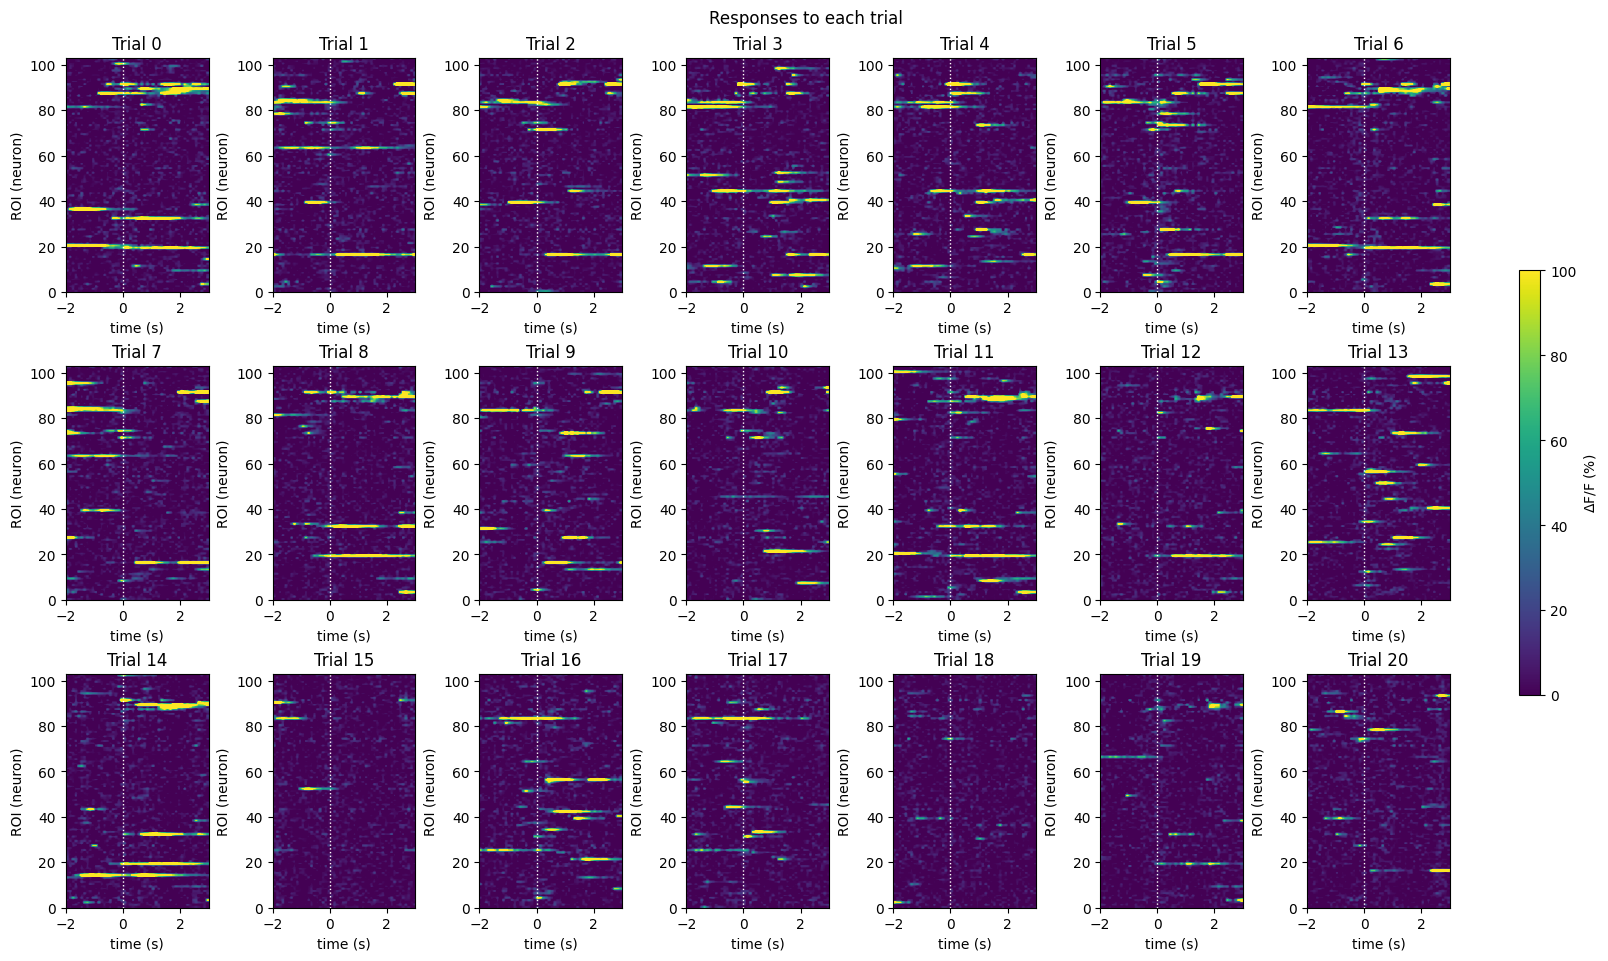

In [16]:
show_many_responses(windows,
                    3,
                    7,
                    title="Responses to each trial",
                    subplot_title="Trial",
                    xlabel="time (s)",
                    ylabel="ROI (neuron)",
                    cbar_label="$\Delta$F/F (%)")

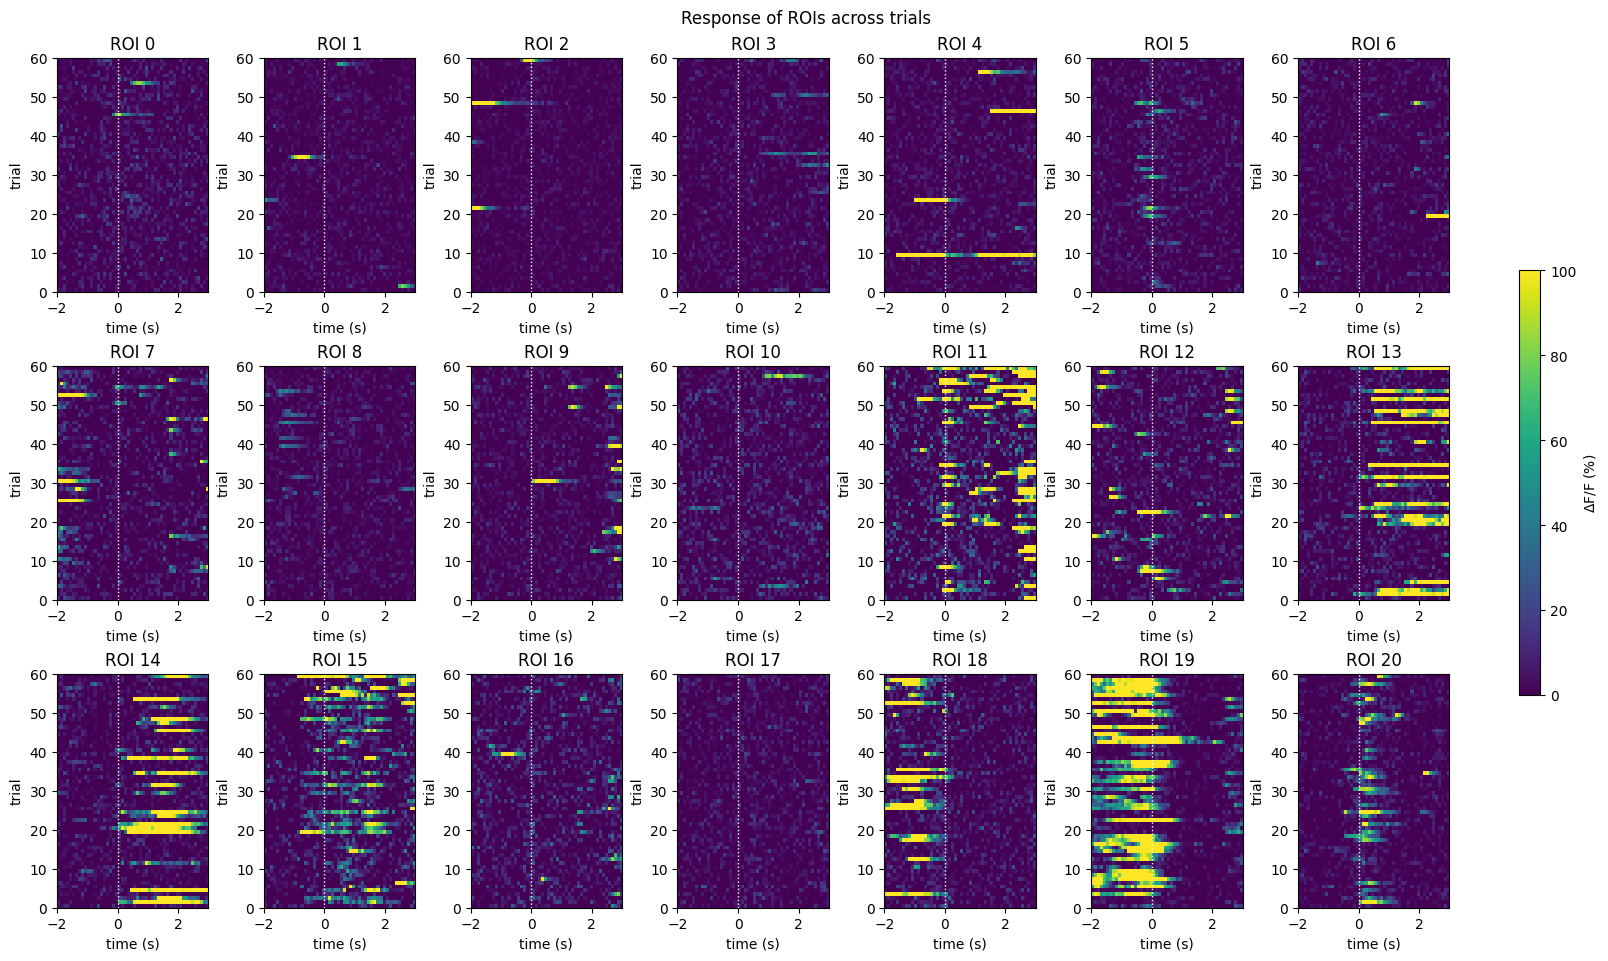

In [17]:
neuronwise_windows = np.swapaxes(windows,0,1)
show_many_responses(neuronwise_windows,
                    3,
                    7,
                    title="Response of ROIs across trials",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")

### Aligning Time Windows
The stimulus windows are averaged across all stimulus trials to get an average view of how the ROIs respond. Use this to compare to the mean responses of the selected neurons after each inclusion criteria.

(103, 50)


Text(0, 0.5, 'ROI (neuron)')

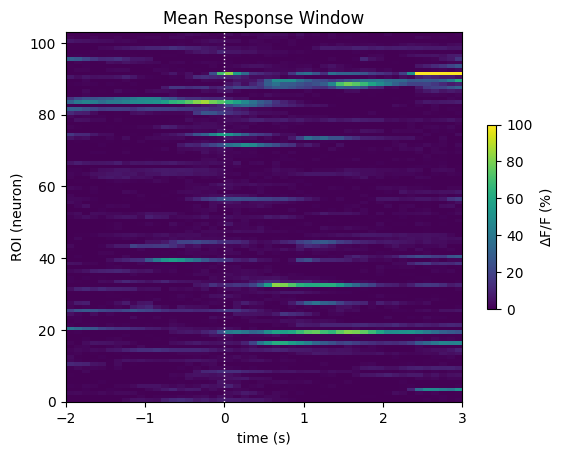

In [18]:
mean_window = np.mean(windows, axis=0)
print(mean_window.shape)
fig, ax = plt.subplots()
show_dff_response(ax, mean_window, window_start_time, window_end_time, vmin=0, vmax=100, cbar_label="$\Delta$F/F (%)")
ax.set_title("Mean Response Window")
ax.set_xlabel("time (s)")
ax.set_ylabel("ROI (neuron)")

### Getting Stimulus Window Info
We calculate a few values which will be applicable to multiple inclusion criteria.

In [19]:
# get the index within the window that stimulus occurs (time 0)
stimulus_onset_idx = int(-window_start_time * interp_hz)
baseline = windows[:,:,0:stimulus_onset_idx]
evoked_responses = windows[:,:,stimulus_onset_idx:]

print(stimulus_onset_idx)
print(baseline.shape)
print(evoked_responses.shape)

20
(60, 103, 20)
(60, 103, 30)


### Inclusion Criteria

#### Inclusion Criterion 1
The maximum value of the mean evoked response is >10% [{cite}`Sun2016`](https://rdcu.be/dbFb9)

In [20]:
mean_evoked_responses = np.mean(evoked_responses, axis=0)
max_mean_evoked_responses = np.max(mean_evoked_responses, axis=1)
IC1_selected_rois = np.where(max_mean_evoked_responses > 10)[0]
print(f"Selected ROIs {IC1_selected_rois}")

Selected ROIs [ 7  9 11 12 13 14 15 19 20 21 22 28 29 31 46 58 59 62 63 64 69 70 75 77
 78 81 83 86 88 94 99]


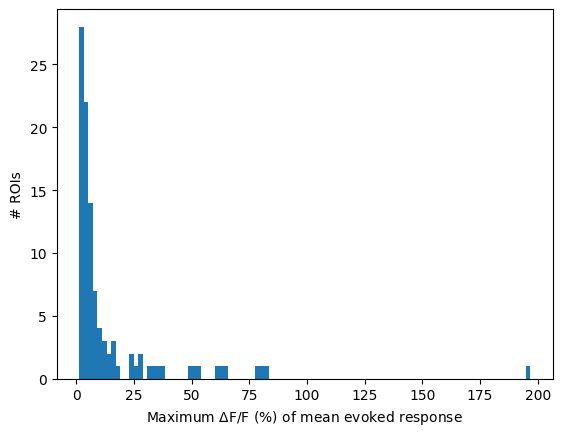

In [21]:
plt.hist(max_mean_evoked_responses, bins=100)
plt.ylabel("# ROIs")
plt.xlabel("Maximum $\Delta$F/F (%) of mean evoked response")
plt.show()

31 / 103 ROIs selected


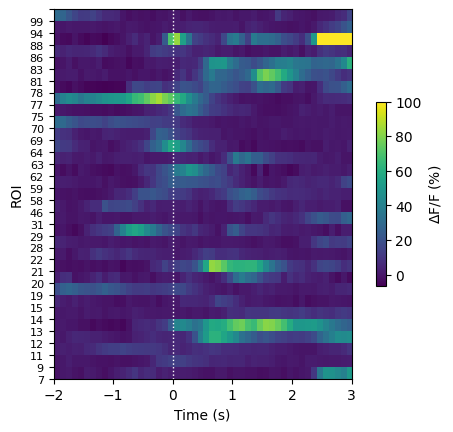

In [22]:
print(f"{len(IC1_selected_rois)} / {windows.shape[1]} ROIs selected")
fig, ax = plt.subplots()
show_dff_response(ax,
                  mean_window[IC1_selected_rois],
                  window_start_time, window_end_time,
                  aspect=0.2,
                  yticklabels=IC1_selected_rois,
                  cbar_label="$\Delta$F/F (%)",
                  vmax=100)

#### Inclusion Criterion 2
In 50% of trials, the evoked response is A) larger than 3x the SD of the baseline, and B) larger than 5% dF/F [{cite}`Roth2012`](https://www.jneurosci.org/content/jneuro/32/28/9716.full.pdf)

In [23]:
all_baseline_sds = np.std(baseline, axis=2)
print(all_baseline_sds.shape)

max_responses = np.max(evoked_responses, axis=2)
print(max_responses.shape)

(60, 103)
(60, 103)


In [24]:
# rois in each trial that respond more than 3x the SD of baseline
deviant_responses = max_responses > 3*all_baseline_sds
# rois in each trial that response more than 5% dff
large_responses = max_responses > 5
# rois in each trial that do both of the above
sig_responses = deviant_responses & large_responses

# rois that have significant responses in 50% or more trials
half_trials = sig_responses.shape[0] / 2
IC2_selected_rois = np.where( np.sum(sig_responses, axis=0) > half_trials )[0]
print(f"Selected ROIs {IC2_selected_rois}")

Selected ROIs [11 15 20 31]


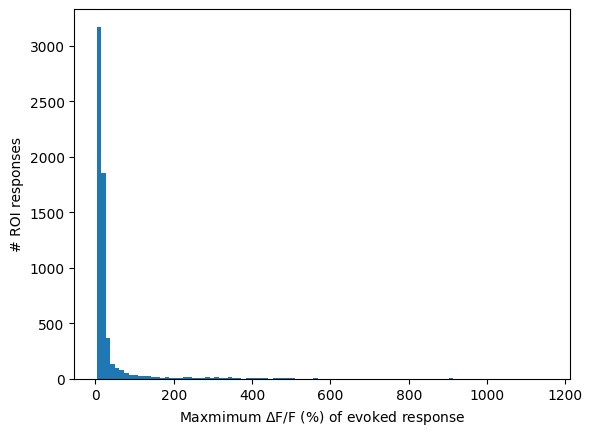

In [25]:
plt.hist(max_responses.flatten(), bins=100)
plt.ylabel("# ROI responses")
plt.xlabel("Maxmimum $\Delta$F/F (%) of evoked response")
plt.show()

4 / 103 ROIs selected


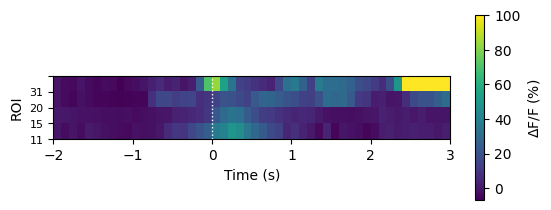

In [26]:
print(f"{len(IC2_selected_rois)} / {windows.shape[1]} ROIs selected")
fig, ax = plt.subplots()
show_dff_response(ax,
                  mean_window[IC2_selected_rois],
                  window_start_time,
                  window_end_time,
                  aspect=0.2,
                  yticklabels=IC2_selected_rois,
                  cbar_label="$\Delta$F/F (%)",
                  vmax=100)

#### Inclusion Criterion 3
Paired T-test (p < 0.05) with Bonferroni correction, comparing the mean baseline to the mean evoked response [{cite}`Andermann2011`](https://pubmed.ncbi.nlm.nih.gov/22196337/)

In [27]:
mean_trial_responses = np.mean(evoked_responses, axis=2)
mean_trial_baselines = np.mean(baseline, axis=2)

n = mean_trial_responses.shape[0]
t,p = ttest_ind(mean_trial_responses, mean_trial_baselines)
IC3_selected_rois = np.where(p < 0.05 / n)[0]
print(f"Selected ROIs {IC3_selected_rois}")

Selected ROIs [11 13 14 15 17 18 19 20 41 70 80 83 92 93 96]


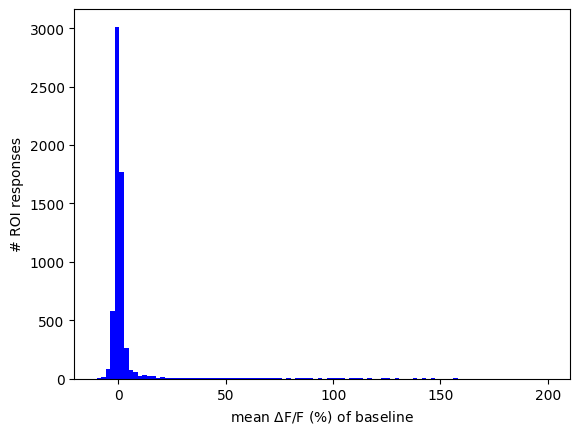

In [28]:
plt.hist(mean_trial_baselines.flatten(), bins=100, range=(-10,200), color="b")
plt.ylabel("# ROI responses")
plt.xlabel("mean $\Delta$F/F (%) of baseline")
plt.show()

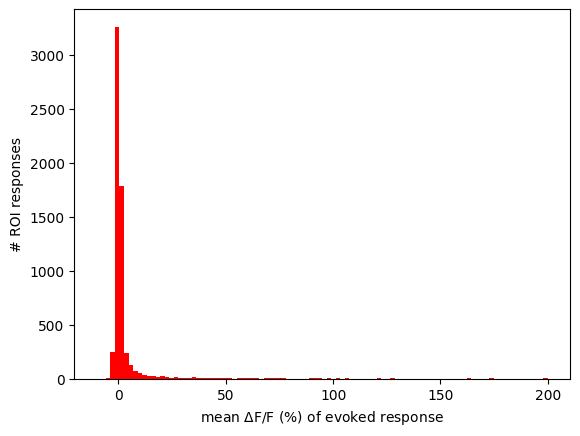

In [29]:
plt.hist(mean_trial_responses.flatten(), bins=100, range=(-10,200), color="r")
plt.ylabel("# ROI responses")
plt.xlabel("mean $\Delta$F/F (%) of evoked response")
plt.show()

15 / 103 ROIs selected


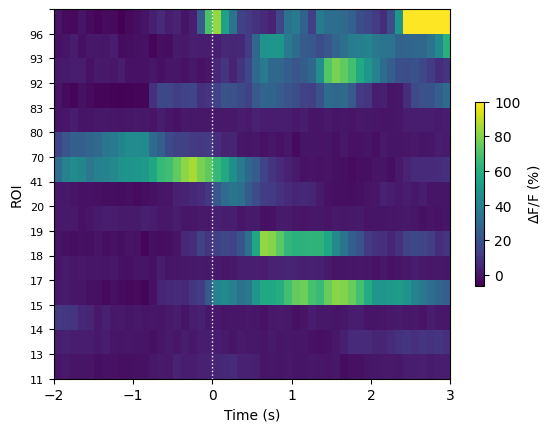

In [30]:
print(f"{len(IC3_selected_rois)} / {windows.shape[1]} ROIs selected")
fig, ax = plt.subplots()
show_dff_response(ax,
                  mean_window[IC3_selected_rois],
                  window_start_time,
                  window_end_time,
                  yticklabels=IC3_selected_rois,
                  cbar_label="$\Delta$F/F (%)",
                  vmax=100)

#### Inclusion Criterion 4
A) The mean response to any stimulus condition is is > 6% dF/F and B) reliability > 1 [{cite}`Marshel2012`](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3248795/). It can be seen that in this example, no ROIs are selected. This is probably due to no ROIs having reliable responses to the stimulus.

In [31]:
mean_trial_responses = np.mean(evoked_responses, axis=2)
response_means = np.mean(mean_trial_responses, axis=0)
response_sds = np.std(mean_trial_responses, axis=0)

mean_trial_baselines = np.mean(baseline, axis=2)
baseline_means = np.mean(mean_trial_baselines, axis=0)
baseline_sds = np.std(mean_trial_baselines, axis=0)

reliabilities = (response_means - baseline_means) / (response_sds + baseline_sds)

In [32]:
sig_reliabilities = reliabilities > 1
large_responses = response_means > 6
IC4_selected_rois = np.where(sig_reliabilities & large_responses)[0]
print(f"Selected ROIs {IC4_selected_rois}")

Selected ROIs []


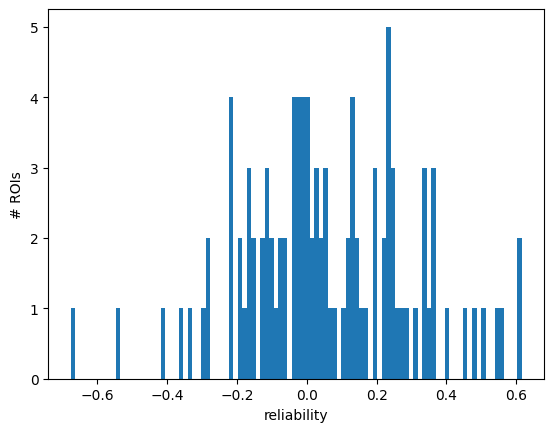

In [33]:
plt.hist(reliabilities, bins=100)
plt.ylabel("# ROIs")
plt.xlabel("reliability")
plt.show()

0 / 103 ROIs selected
Input data has length 0; Nothing to display


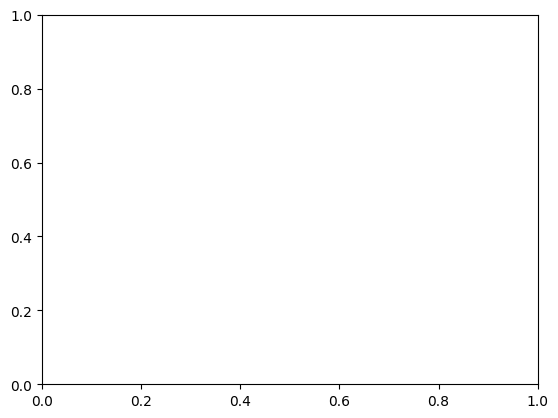

In [34]:
print(f"{len(IC4_selected_rois)} / {windows.shape[1]} ROIs selected")
fig, ax = plt.subplots()
show_dff_response(ax,
                  mean_window[IC4_selected_rois],
                  window_start_time,
                  window_end_time,
                  yticklabels=IC4_selected_rois,
                  cbar_label="$\Delta$F/F (%)",
                  vmax=100)

#### Inclusion Criterion 5
The maximum evoked response to any stimulus condition is > 4% dF/F [{cite}`Tohmi2014`](https://pubmed.ncbi.nlm.nih.gov/24583013/). This criterion is clearly the most permissive, as it includes all ROIs.

In [35]:
max_responses = np.max(evoked_responses, axis=2)
IC5_selected_rois = np.where( np.any(max_responses > 4, axis=0) )[0]
print(f"Selected ROIs {IC5_selected_rois}")

Selected ROIs [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102]


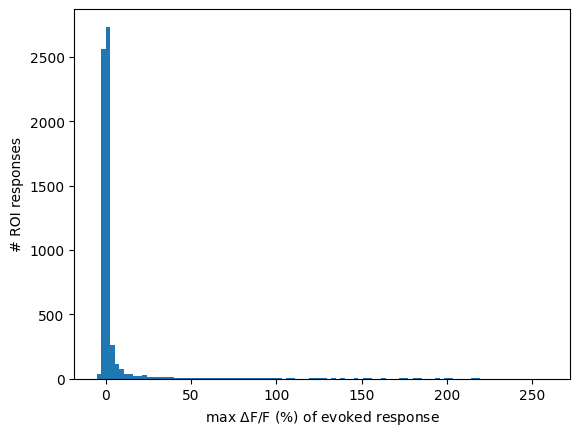

In [36]:
plt.hist(mean_trial_responses.flatten(), bins=100)
plt.ylabel("# ROI responses")
plt.xlabel("max $\Delta$F/F (%) of evoked response")
plt.show()

103 / 103 ROIs selected


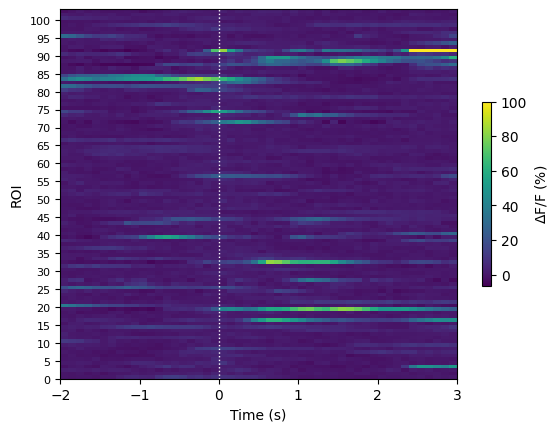

In [37]:
print(f"{len(IC5_selected_rois)} / {windows.shape[1]} ROIs selected")
fig, ax = plt.subplots()
show_dff_response(ax,
                  mean_window[IC5_selected_rois],
                  window_start_time,
                  window_end_time,
                  yticklabels=IC5_selected_rois,
                  skipticks=5,
                  cbar_label="$\Delta$F/F (%)",
                  vmax=100)